Saving failure_flags.csv to failure_flags (3).csv
✅ File loaded: failure_flags (3).csv


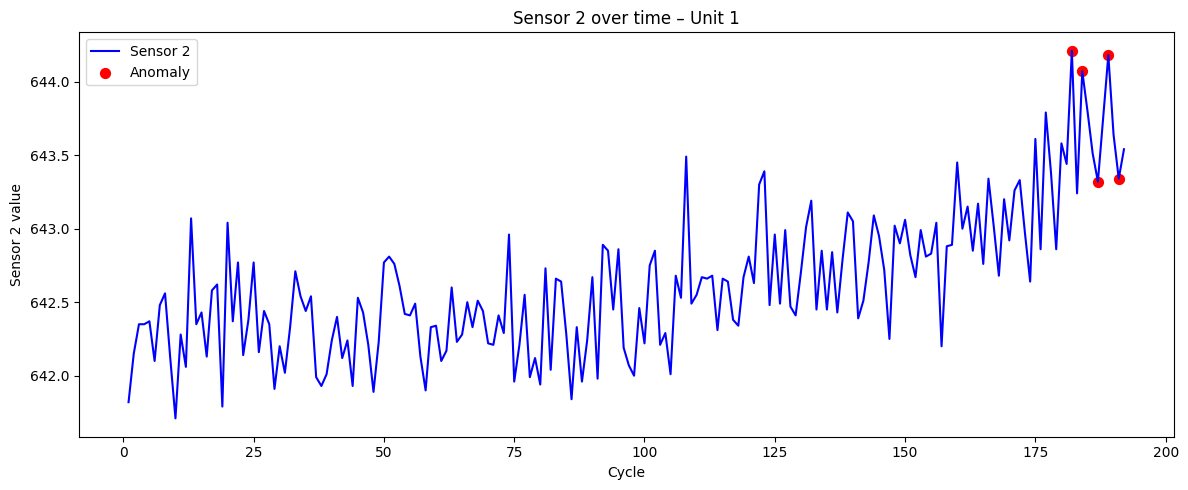

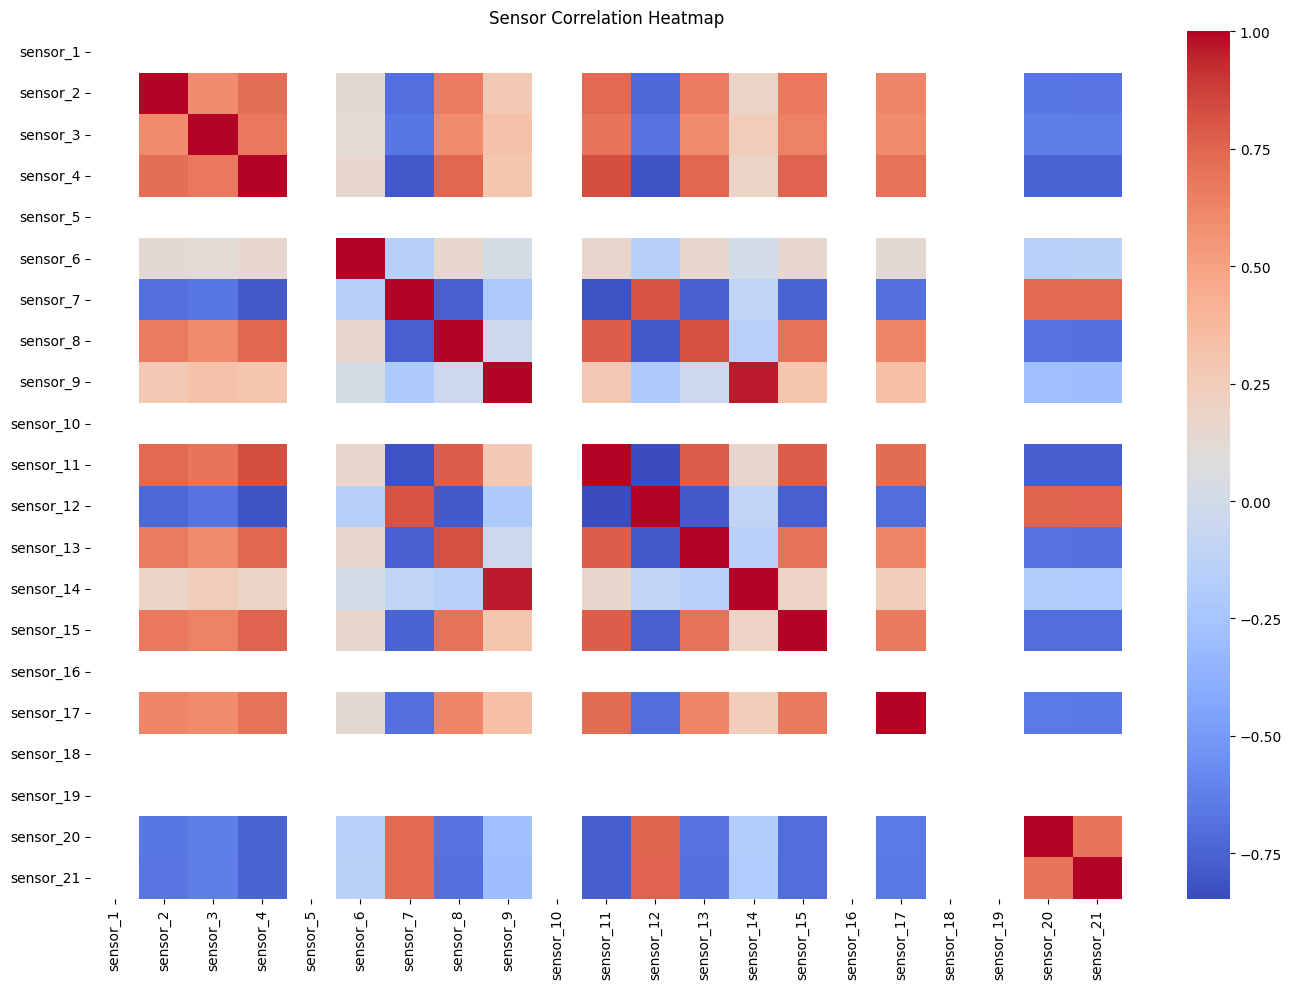

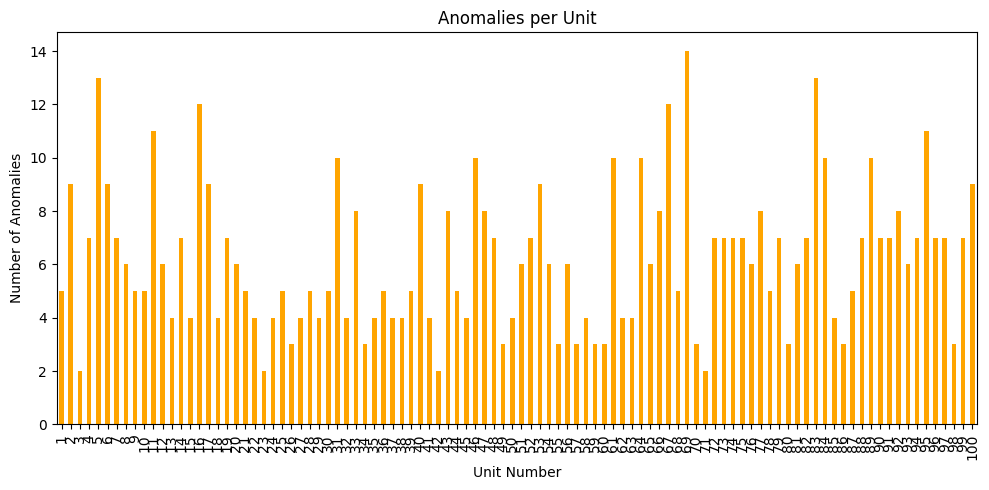

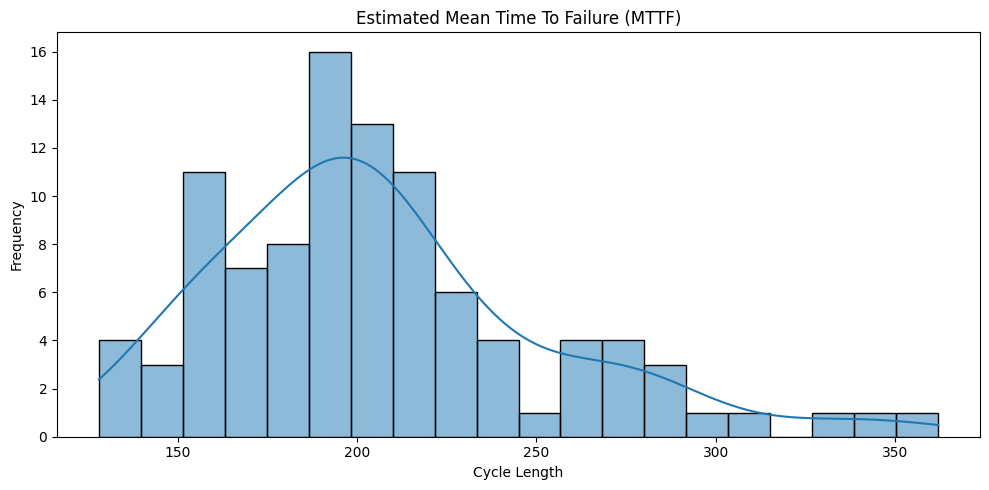

🚀 Training XGBoost model to predict anomaly_flag...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:51:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score      support
0              0.995270  0.997505  0.996386  4008.000000
1              0.909091  0.840336  0.873362   119.000000
accuracy       0.992973  0.992973  0.992973     0.992973
macro avg      0.952181  0.918921  0.934874  4127.000000
weighted avg   0.992785  0.992973  0.992839  4127.000000


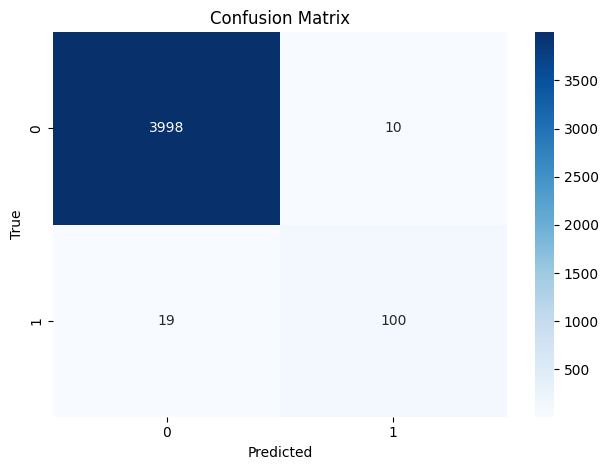

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# 📦 Import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import shutil

# Tạo thư mục
os.makedirs('img', exist_ok=True)
os.makedirs('models', exist_ok=True)

# 📤 Upload file từ máy
uploaded = files.upload()
file_path = list(uploaded.keys())[0]

# 📥 Đọc dữ liệu
df = pd.read_csv(file_path)
print(f"✅ File loaded: {file_path}")

# 📈 Vẽ biểu đồ sensor_2 + anomaly
unit_id = 1
df_unit = df[df['unit_number'] == unit_id]
plt.figure(figsize=(12, 5))
plt.plot(df_unit['cycle'], df_unit['sensor_2'], label='Sensor 2', color='blue')
plt.scatter(df_unit[df_unit['anomaly_flag'] == 1]['cycle'],
            df_unit[df_unit['anomaly_flag'] == 1]['sensor_2'],
            color='red', label='Anomaly', s=50)
plt.title(f'Sensor 2 over time – Unit {unit_id}')
plt.xlabel('Cycle'); plt.ylabel('Sensor 2 value'); plt.legend()
plt.tight_layout(); plt.savefig('img/sensor2_anomaly_unit1.png'); plt.show()

# 🔥 Heatmap tương quan các sensor
sensor_cols = [col for col in df.columns if col.startswith('sensor_') and '_z' not in col and '_roll' not in col]
plt.figure(figsize=(14, 10))
sns.heatmap(df[sensor_cols].corr(), cmap='coolwarm')
plt.title('Sensor Correlation Heatmap')
plt.tight_layout(); plt.savefig('img/sensor_correlation_heatmap.png'); plt.show()

# 📊 Anomaly per unit
anomaly_per_unit = df.groupby('unit_number')['anomaly_flag'].sum()
plt.figure(figsize=(10, 5))
anomaly_per_unit.plot(kind='bar', color='orange')
plt.title('Anomalies per Unit')
plt.xlabel('Unit Number'); plt.ylabel('Number of Anomalies')
plt.tight_layout(); plt.savefig('img/anomaly_per_unit.png'); plt.show()

# 📉 MTTF distribution
mttf_df = df.groupby('unit_number')['cycle'].max()
plt.figure(figsize=(10, 5))
sns.histplot(mttf_df, bins=20, kde=True)
plt.title('Estimated Mean Time To Failure (MTTF)')
plt.xlabel('Cycle Length'); plt.ylabel('Frequency')
plt.tight_layout(); plt.savefig('img/mttf_distribution.png'); plt.show()

# 🚀 ML MỞ RỘNG: Dự đoán anomaly_flag bằng XGBoost
print("🚀 Training XGBoost model to predict anomaly_flag...")

# Chọn các cột đầu vào
feature_cols = [col for col in df.columns if col.startswith('sensor_') and '_z' not in col and '_roll' not in col]
X = df[feature_cols]
y = df['anomaly_flag']

# Tách train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)

# Đánh giá
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('models/classification_report.csv')
print(report_df)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.savefig('img/confusion_matrix.png'); plt.show()

# Lưu mô hình
model.save_model('models/xgb_anomaly_model.json')

# 📦 Nén và tải toàn bộ thư mục ảnh + mô hình
shutil.make_archive('sensor_img', 'zip', 'img')
files.download('sensor_img.zip')

shutil.make_archive('model_files', 'zip', 'models')
files.download('model_files.zip')
